## SCT Toolbox

**Author:** Steffen Bollmann

**Citation:**
- Valošek, J., & Cohen-Adad, J. (2024). Reproducible spinal cord quantitative MRI analysis with the Spinal Cord Toolbox. Magnetic Resonance in Medical Sciences, 23(3), 307-315. [https://doi.org/10.2463/mrms.rev.2023-0159](https://doi.org/10.2463/mrms.rev.2023-0159)
- Neurolibre [SCT pipeline](https://mathieuboudreau.github.io/pipelines-jupyter-book/01/sct_mtsat)

### Output CPU information

In [2]:
# Output CPU information:
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: AuthenticAMD
model name	: AMD EPYC 7742 64-Core Processor


# Demonstrating the Spinal Cord Toolbox (SCT) use via Neurodesk

In Neurodesk we can use module to load specific versions of tools. Here we load the spinalcordtoolbox in a specific version:

In [3]:
import module
await module.load('spinalcordtoolbox/5.8')
await module.list()

['spinalcordtoolbox/5.8']

In this interactive notebook we will go through a series of processing steps specific to spinal cord MRI analysis. We first need to import the necessary tools and setup the filenames and folders in the notebook environment.

The rest of this notebook is copied from the neurolibre project with minor path modifications and code adjustments to work with the [current version of SCT](https://mathieuboudreau.github.io/pipelines-jupyter-book/01/sct_mtsat)

In [ ]:
%%capture
!pip install numpy pandas

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import os
from os.path import join
from IPython.display import clear_output

base_path = os.getcwd()

In [5]:
# Download example data
!sct_download_data -d sct_example_data -o ./sct_example_data

# Go to MT folder
os.chdir('./sct_example_data/mt/')


--
Spinal Cord Toolbox (5.8)

sct_download_data -d sct_example_data -o ./sct_example_data
--

Removing existing destination folder 'sct_example_data'
Trying URL: https://github.com/spinalcordtoolbox/sct_example_data/releases/download/r20180525/20180525_sct_example_data.zip
Downloading: 20180525_sct_example_data.zip
Status: 100%|██████████████████████████████| 44.3M/44.3M [00:02<00:00, 19.2MB/s]
Creating temporary folder (/tmp/sct-20230615031915.792117-lazrhizb)
Unzip data to: /tmp/sct-20230615031915.792117-lazrhizb
Copying data to: sct_example_data
Removing temporary folders...
Done!



In [6]:
# Jupyter Notebook config
verbose = True # False clears cells

# Folder/filename config
parent_dirs = os.path.split(base_path)
mt_folder_relative = os.path.join('sct_example_data/mt')
qc_path = os.path.join(base_path, 'qc')

t1w = 't1w'
mt0 = 'mt0'
mt1 = 'mt1'
label_c3c4 = 'label_c3c4'
warp_template2anat = 'warp_template2anat'
mtr = 'mtr'
mtsat = 'mtsat'
t1map = 't1map'

file_ext = '.nii.gz'

if not verbose:
    clear_output()

The first processing step consists in segmenting the spinal cord. This is done automatically using an algorithm called Optic that finds the spinal cord centerline, followed by a second algorithm called DeepSeg-SC that relies on deep learning for segmenting the cord.

In [7]:
# Segment spinal cord
!sct_deepseg_sc -i {t1w+file_ext} -c t1 -qc {qc_path}

if not verbose:
    clear_output()


--
Spinal Cord Toolbox (5.8)

sct_deepseg_sc -i t1w.nii.gz -c t1 -qc /home/jovyan/example-notebooks/structural_imaging/qc
--

Config deepseg_sc:
  Centerline algorithm: svm
  Brain in image: True
  Kernel dimension: 2d
  Contrast: t1
  Threshold: 0.15
Creating temporary folder (/tmp/sct-20230615031921.202846-b6pbyd5_)
Reorient the image to RPI, if necessary...
Finding the spinal cord centerline...
Creating temporary folder (/tmp/sct-20230615031922.023141-6cp904ym)
Remove temporary files...
rm -rf /tmp/sct-20230615031922.023141-6cp904ym
Cropping the image around the spinal cord...
Normalizing the intensity...
Segmenting the spinal cord using deep learning on 2D patches...
Reassembling the image...
Resampling the segmentation to the native image resolution using linear interpolation...
Binarizing the resampled segmentation...
Image header specifies datatype 'float32', but array is of type 'uint8'. Header metadata will be overwritten to use 'uint8'.
Compute shape analysis: 100%|#########

Results of the segmentation appear in Figure 1.

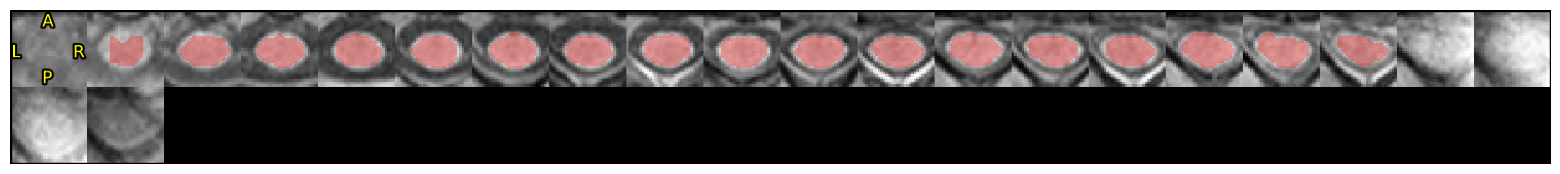

In [8]:
# Plot QC figures

if sys.platform == 'darwin':
    # For local testing on OSX    
    sct_deepseg_sc_qc = 'qc/sct_example_data/mt/sct_deepseg_sc'
else:
    # For linux and on-line Binder execution
    sct_deepseg_sc_qc = join(qc_path, parent_dirs[-1], mt_folder_relative, 'sct_deepseg_sc')

folders = list(filter(lambda x: os.path.isdir(os.path.join(sct_deepseg_sc_qc, x)), os.listdir(sct_deepseg_sc_qc)))

qc_date = max(folders)

sct_deepseg_sc_qc_dir = join(sct_deepseg_sc_qc, qc_date)

bkg = mpimg.imread(join(sct_deepseg_sc_qc_dir, 'bkg_img.png'))
overlay = mpimg.imread(join(sct_deepseg_sc_qc_dir, 'overlay_img.png'))
plt.figure(figsize = (20,2))
plt.axis('off')
imgplot = plt.imshow(bkg)
imgplot = plt.imshow(overlay,alpha=0.3)

Figure 1. Quality control (QC) SCT module segmentation results. The segmentation (in red) is overlaid on the T1-weighted anatomical scan (in grayscale). Orientation is axial.



Using the generated segmentation, we create a mask around the spinal cord which will be used to crop the image for faster processing and more accurate registration results: the registration algorithm will concentrate on the spinal cord and not on the surrounding tissue (e.g., muscles, neck fat, etc.) which could move independently from the spinal cord and hence produce spurious motion correction results.

In [9]:
# Create mask
!sct_create_mask -i {t1w+file_ext} -p centerline,{t1w+'_seg'+file_ext} -size 35mm -o {t1w+'_mask'+file_ext}

# Crop data for faster processing
!sct_crop_image -i {t1w+file_ext} -m {t1w+'_mask'+file_ext} -o {t1w+'_crop'+file_ext}

if not verbose:
    clear_output()


--
Spinal Cord Toolbox (5.8)

sct_create_mask -i t1w.nii.gz -p centerline,t1w_seg.nii.gz -size 35mm -o t1w_mask.nii.gz
--

  OK: t1w_seg.nii.gz
Creating temporary folder (/tmp/sct-20230615031929.970280-create_mask-uyscn4aj)

Orientation:
  LPI

Dimensions:
(192, 192, 22, 1, 0.8958333, 0.8958333, 5.000001, 1)

Create mask...
/opt/spinalcordtoolbox-5.8/spinalcordtoolbox/scripts/sct_create_mask.py:230: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  hdr = centerline.get_header()  # get header
/opt/spinalcordtoolbox-5.8/spinalcordtoolbox/scripts/sct_create_mask.py:233: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.de

Then, we register the proton density weighted (PD) image to the T1w image, and the MT-weighted image to the T1w image, so we end up with the T1w, MTw and PDw images all aligned together, which is a necessary condition for then computing quantitative MR metrics (here: MTsat).



In [10]:
# Register PD->T1w
# Tips: here we only use rigid transformation because both images have very similar sequence parameters. We don't want to use SyN/BSplineSyN to avoid introducing spurious deformations.
!sct_register_multimodal -i {mt0+file_ext} -d {t1w+'_crop'+file_ext} -param step=1,type=im,algo=rigid,slicewise=1,metric=CC -x spline

# Register MT->T1w
!sct_register_multimodal -i {mt1+file_ext} -d {t1w+'_crop'+file_ext} -param step=1,type=im,algo=rigid,slicewise=1,metric=CC -x spline

if not verbose:
    clear_output()


--
Spinal Cord Toolbox (5.8)

sct_register_multimodal -i mt0.nii.gz -d t1w_crop.nii.gz -param step=1,type=im,algo=rigid,slicewise=1,metric=CC -x spline
--


Input parameters:
  Source .............. mt0.nii.gz (192, 192, 22)
  Destination ......... t1w_crop.nii.gz (45, 43, 17)
  Init transfo ........ 
  Mask ................ 
  Output name ......... 
  Remove temp files ... 1
  Verbose ............. 1

Check if input data are 3D...
Creating temporary folder (/tmp/sct-20230615031937.629746-register-d3p7boj6)

Copying input data to tmp folder and convert to nii...

--
ESTIMATE TRANSFORMATION FOR STEP #0
Registration parameters:
  type ........... im
  algo ........... syn
  slicewise ...... 0
  metric ......... MI
  samplStrategy .. None
  samplPercent ... 0.2
  iter ........... 0
  smooth ......... 0
  laplacian ...... 0
  shrink ......... 1
  gradStep ....... 0.5
  deformation .... 1x1x0
  init ........... 
  poly ........... 5
  filter_size .... 5
  dof ............ Tx_Ty_Tz_Rx_Ry_Rz

Next step consists in registering the PAM50 template to the T1w image. We first create a label, centered in the spinal cord at level C3-C4 intervertebral disc, then we apply a multi-step non-linear registration algorithm.

In [11]:
# Create label 4 at the mid-FOV, because we know the FOV is centered at C3-C4 disc.
!sct_label_utils -i {t1w+'_seg'+file_ext} -create-seg-mid 4 -o {label_c3c4+file_ext}

# Register template->T1w_ax (using template-T1w as initial transformation)
!sct_register_to_template -i {t1w+'_crop'+file_ext} -s {t1w+'_seg'+file_ext} -ldisc {label_c3c4+file_ext} -ref subject -c t1 -param step=1,type=seg,algo=slicereg,metric=MeanSquares,smooth=2:step=2,type=im,algo=bsplinesyn,metric=MeanSquares,iter=5,gradStep=0.5 -qc {qc_path}

if not verbose:
    clear_output()


--
Spinal Cord Toolbox (5.8)

sct_label_utils -i t1w_seg.nii.gz -create-seg-mid 4 -o label_c3c4.nii.gz
--

Generating output files...

--
Spinal Cord Toolbox (5.8)

sct_register_to_template -i t1w_crop.nii.gz -s t1w_seg.nii.gz -ldisc label_c3c4.nii.gz -ref subject -c t1 -param step=1,type=seg,algo=slicereg,metric=MeanSquares,smooth=2:step=2,type=im,algo=bsplinesyn,metric=MeanSquares,iter=5,gradStep=0.5 -qc /home/jovyan/example-notebooks/structural_imaging/qc
--


Check template files...
  OK: /opt/spinalcordtoolbox-5.8/data/PAM50/template/PAM50_t1.nii.gz
  OK: /opt/spinalcordtoolbox-5.8/data/PAM50/template/PAM50_label_disc.nii.gz
  OK: /opt/spinalcordtoolbox-5.8/data/PAM50/template/PAM50_cord.nii.gz

Check parameters:
  Data:                 t1w_crop.nii.gz
  Landmarks:            label_c3c4.nii.gz
  Segmentation:         t1w_seg.nii.gz
  Path template:        /opt/spinalcordtoolbox-5.8/data/PAM50
  Remove temp files:    1

Check input labels...
Creating temporary folder (/tmp/sct-202

Once the PAM50 is registered with the T1w image, we can warp all objects pertaining to the PAM50 into the T1w native space. These objects notably include a white matter atlas, which will be subsequently used to extract qMR metrics within specific white matter tracts.

In [12]:
# Warp template
!sct_warp_template -d {t1w+'_crop'+file_ext} -w {warp_template2anat+file_ext} -qc {qc_path}

if not verbose:
    clear_output()


--
Spinal Cord Toolbox (5.8)

sct_warp_template -d t1w_crop.nii.gz -w warp_template2anat.nii.gz -qc /home/jovyan/example-notebooks/structural_imaging/qc
--


Check parameters:
  Working directory ........ /home/jovyan/example-notebooks/structural_imaging/sct_example_data/mt
  Destination image ........ t1w_crop.nii.gz
  Warping field ............ warp_template2anat.nii.gz
  Path template ............ /opt/spinalcordtoolbox-5.8/data/PAM50
  Output folder ............ label


WARP TEMPLATE:
/opt/spinalcordtoolbox-5.8/bin/isct_antsApplyTransforms -d 3 -i /opt/spinalcordtoolbox-5.8/data/PAM50/template/PAM50_t1.nii.gz -o label/template/PAM50_t1.nii.gz -t warp_template2anat.nii.gz -r t1w_crop.nii.gz -n Linear # in /home/jovyan/example-notebooks/structural_imaging/sct_example_data/mt
/opt/spinalcordtoolbox-5.8/bin/isct_antsApplyTransforms -d 3 -i /opt/spinalcordtoolbox-5.8/data/PAM50/template/PAM50_t2.nii.gz -o label/template/PAM50_t2.nii.gz -t warp_template2anat.nii.gz -r t1w_crop.nii.gz -n

Results of the registration/warming appear in Figure 2.

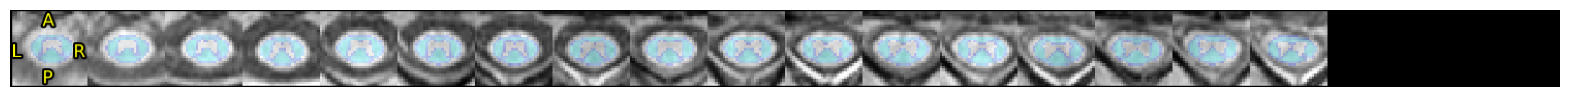

In [13]:
# Plot QC figures
if sys.platform == 'darwin':
    # For local testing on OSX    
    sct_warp_template_qc = 'qc/sct_example_data/mt/sct_warp_template'
else:
    # For linux and on-line Binder execution
    sct_warp_template_qc = join(qc_path, parent_dirs[-1],  mt_folder_relative, 'sct_warp_template')

folders = list(filter(lambda x: os.path.isdir(os.path.join(sct_warp_template_qc, x)), os.listdir(sct_warp_template_qc)))
qc_date = max(folders)

sct_warp_template_qc_dir = join(sct_warp_template_qc, qc_date)

bkg = mpimg.imread(join(sct_warp_template_qc_dir, 'bkg_img.png'))
overlay = mpimg.imread(join(sct_warp_template_qc_dir, 'overlay_img.png'))
plt.figure(figsize = (20,2))
plt.axis('off')
imgplot = plt.imshow(bkg)
imgplot = plt.imshow(overlay,alpha=0.3)

Figure 2. Quality control (QC) SCT module registration/warping results of the PAM50 template and atlas to the T1w native space. The white matter (in blue) is overlaid on the T1-weighted anatomical scan (in grayscale). Orientation is axial.Once co-registration between images and registration to the template is complete, we can venture into computing our favorite qMR metrics. Here, we compute the magnetization transfer ratio (MTR) and the magnetization transfer saturation (MTsat).



Once co-registration between images and registration to the template is complete, we can venture into computing our favorite qMR metrics. Here, we compute the magnetization transfer ratio (MTR) and the magnetization transfer saturation (MTsat).

In [14]:
# Compute MTR
!sct_compute_mtr -mt1 {mt1+'_reg'+file_ext} -mt0 {mt0+'_reg'+file_ext}

# Compute MTsat and T1
!sct_compute_mtsat -mt {mt1+'_reg'+file_ext} -pd {mt0+'_reg'+file_ext} -t1 {t1w+'_crop'+file_ext} -trmt 57 -trpd 57 -trt1 15 -famt 9 -fapd 9 -fat1 15

if not verbose:
    clear_output()


--
Spinal Cord Toolbox (5.8)

sct_compute_mtr -mt1 mt1_reg.nii.gz -mt0 mt0_reg.nii.gz
--


Compute MTR...
Found 0 voxels with value=0. These will be replaced by nan.
Threshold to clip values: +/- 100

--
Spinal Cord Toolbox (5.8)

sct_compute_mtsat -mt mt1_reg.nii.gz -pd mt0_reg.nii.gz -t1 t1w_crop.nii.gz -trmt 57 -trpd 57 -trt1 15 -famt 9 -fapd 9 -fat1 15
--

Load data...
Compute T1 map...
R1 values were found to be lower than 0.01. They will be set to inf, producing T1=0 for these voxels.
Compute A...
Compute MTsat...
MTsat values were found to be larger than 1. They will be set to zero for these voxels.
Generate output files...


Now that our metrics are computed, we want to extract their values within specific tracts of the spinal cord. This is done with the function sct_extract_metric.

In [15]:
# Extract MTR, MTsat and T1 in WM between C2 and C4 vertebral levels
!sct_extract_metric -i mtr.nii.gz -l 51 -vert 2:4 -perlevel 1 -o mtr_in_wm.csv
!sct_extract_metric -i mtsat.nii.gz -l 51 -vert 2:4 -perlevel 1 -o mtsat_in_wm.csv
!sct_extract_metric -i t1map.nii.gz -l 51 -vert 2:4 -perlevel 1 -o t1_in_wm.csv

if not verbose:
    clear_output()


--
Spinal Cord Toolbox (5.8)

sct_extract_metric -i mtr.nii.gz -l 51 -vert 2:4 -perlevel 1 -o mtr_in_wm.csv
--


Load metric image...
Estimation for label: white matter

Done! To view results, type:
xdg-open mtr_in_wm.csv


--
Spinal Cord Toolbox (5.8)

sct_extract_metric -i mtsat.nii.gz -l 51 -vert 2:4 -perlevel 1 -o mtsat_in_wm.csv
--


Load metric image...
Estimation for label: white matter

Done! To view results, type:
xdg-open mtsat_in_wm.csv


--
Spinal Cord Toolbox (5.8)

sct_extract_metric -i t1map.nii.gz -l 51 -vert 2:4 -perlevel 1 -o t1_in_wm.csv
--


Load metric image...
Estimation for label: white matter

Done! To view results, type:
xdg-open t1_in_wm.csv



Results are output as csv files, which we can then open and display as bar graphs.

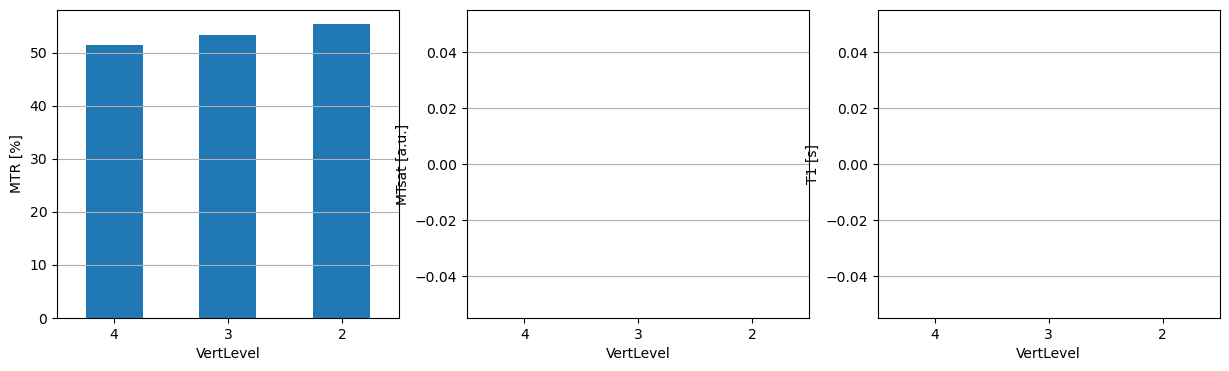

In [17]:
# Display plots of results
import pandas as pd
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

# Build dic for plot
plot_dic = {'file': ['mtr_in_wm.csv', 'mtsat_in_wm.csv', 't1_in_wm.csv'],
            'ylabel': ['MTR [%]', 'MTsat [a.u.]', 'T1 [s]']}

# Loop across dic entries
for i in range(len(plot_dic)+1):
    df = pd.read_csv(plot_dic['file'][i])
    df.plot.bar(x='VertLevel', y='WA()', rot=0, ax=ax[i], legend=False)
    ax[i].set_ylabel(plot_dic['ylabel'][i])
    ax[i].yaxis.grid()

Figure 3. Quantitative MRI metrics in WM between C2 and C4 vertebral levels. The three calculated metrics from this dataset using SCT are the magnetization transfer ratio (MTR – [%]), magnetization transfer saturation (MTsat – [a.u.]), and longitudinal relaxation time (T1 – [s]).